In [258]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

In [259]:
# 코로나 상황인 19~21 년 데이터 학습

df19 = pd.read_csv('test2019.csv', sep=',', encoding="ANSI",index_col=0)
df20 = pd.read_csv('test2020.csv', sep=',', encoding="ANSI",index_col=0)
df21 = pd.read_csv('test2021.csv', sep=',', encoding="ANSI",index_col=0)
df_total = pd.concat([df19,df20,df21])

In [260]:
df_total.reset_index(inplace=True, drop=True)
df_total['기준일ID'] = pd.to_datetime(df_total['기준일ID'], format='%Y%m%d')
df_total['기준일ID'] = pd.to_datetime(df_total['기준일ID'])

df_total['year'] = df_total['기준일ID'].dt.year
df_total['month'] = df_total['기준일ID'].dt.month
df_total['day'] = df_total['기준일ID'].dt.day
df_total = df_total[['year','month','day','시간대구분','총생활인구수']]
df_total.rename(columns={'시간대구분':'hour'},inplace=True)
df_total = df_total.dropna()
df_new = df_total.copy()

# 1주일 주기를 맞추기 위해 2019년 10월 28일을 제거
df_new = df_new.drop(index =df_new[(df_new.year == 2019)&(df_new.month == 10)& (df_new.day == 28)].index).reset_index(drop = True)
df_new = df_new.drop(['year','month','day','hour'], axis=1)
df_new = df_new.dropna()

In [261]:
import datetime

In [262]:
# 만들어진 데이터프레임의 인덱스를 쉽게 알아내기 위해 만든 함수입니다
# timeindex(연,월,일) = 해당 날짜 00시 index

def timeindex (y,m,d):
    targetdate = datetime.date(y, m, d)
    startdate = datetime.date(2019,1,1)
    days = (targetdate-startdate)
    if(y>2019) :
        return (days.days-14) * 24
    if (y>=2019 & m > 10) :
        return (days.days-14) * 24
    if (y>=2019 & m>= 10 & d>14):
        return (days.days-14) * 24 
    else :
        return days.days * 24

In [263]:
# 설날 샌드위치 휴일과 그전주,다음주,평균 감소율을 index 단위로 알아내기 위해 만든 함수입니다
# sandcal(연,월,일,k) = 특정 날짜에서 시작하여 k일 만큼의 해당 주, 전 주, 다음 주의 증감률을 인덱스 단위로 보여주고
# 전 주 증감률과 다음 주 증감률의 평균도 구합니다
 
def sandcal(y,m,d,k):
    sand_index = timeindex(y,m,d)
    sand_start = df_new['총생활인구수'].iloc[sand_index : sand_index + 24*k].reset_index(drop=True)
    sand_bw1 = df_new['총생활인구수'].iloc[sand_index - 24*7 : sand_index - 24*7 +24*k].reset_index(drop=True)
    sand_aw1 = df_new['총생활인구수'].iloc[sand_index +24*7 : sand_index + 24*k + 24*7].reset_index(drop=True)
    
    df = pd.concat([sand_start,sand_bw1], axis=1)
    df = pd.concat([df,sand_aw1], axis=1)
    df.columns = ['명절','전주','다음주']
    df['명절/전주'] = df['명절']/df['전주']
    df['명절/다음주'] = df['명절']/df['다음주']
    df['평균감소'] = (df['명절/전주']+df['명절/다음주'])/2
    return df

In [264]:
seol19 = sandcal(2019,2,1,6)
seol19

,명절,전주,다음주,명절/전주,명절/다음주,평균감소
0,43577.2163,44455.1001,44084.6434,0.980252,0.988490,0.984371
1,43868.0627,44877.8391,44443.7246,0.977499,0.987047,0.982273
2,44092.5674,45164.8923,44749.1431,0.976258,0.985328,0.980793
3,44287.0604,45466.1534,44904.9311,0.974067,0.986240,0.980154
4,44786.8771,45979.5446,45402.9888,0.974061,0.986430,0.980246
...,...,...,...,...,...,...
139,38299.5405,38743.6748,39892.7942,0.988537,0.960062,0.974299
140,38753.2198,39351.6394,40357.1921,0.984793,0.960256,0.972524
141,39170.6563,39929.9070,41215.9288,0.980985,0.950377,0.965681
142,40129.5243,41292.5428,42832.6778,0.971835,0.936890,0.954363


In [265]:
# 예측하고자하는 2022년 1월 1일의 시작은 토요일이기 때문에 토요일인 21년 10월 23일 부터 데이터를 뽑아 테스트에 넣었습니다

print(timeindex(2021,10,23))
print(timeindex(2021,12,28))
print((timeindex(2021,12,28)-timeindex(2021,10,23))/24)

24288
25872
66.0


In [266]:
df_new

,총생활인구수
0,40817.7171
1,40685.6385
2,41398.4914
3,41464.8976
4,41619.0919
...,...
25963,33304.5400
25964,33368.7201
25965,34083.1721
25966,34380.0806


In [267]:
df_newtest = df_new.iloc[24288:25872].reset_index(drop=True)

In [268]:
df_new['1d'] = df_new['총생활인구수'].shift(24)
df_new['7d'] = df_new['총생활인구수'].shift(24*7)

df_newtest['1d'] = df_newtest['총생활인구수'].shift(24)
df_newtest['7d'] = df_newtest['총생활인구수'].shift(24*7)

In [269]:
df_new = df_new.drop(['총생활인구수'], axis=1)
df_new = df_new.dropna()

df_newtest = df_newtest.drop(['총생활인구수'], axis=1)
df_newtest = df_newtest.dropna()

In [270]:
df_newtest

,1d,7d
168,39944.5008,39189.4199
169,39868.2746,38965.6133
170,39857.8817,38803.3962
171,39716.7755,38634.1466
172,39708.2617,38739.5057
...,...,...
1579,36633.0888,35825.8934
1580,36502.0621,36170.0487
1581,37223.0433,36964.8312
1582,37097.6287,37323.8283


In [271]:
train_x = df_new.iloc[:,1:]
train_y = df_new.iloc[ :,:1]

test_x = df_newtest.iloc[ :,1:]
test_y = df_new.iloc[ :,:1]

In [272]:
train_x = train_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)

test_x = test_x.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)

In [273]:
train_x

,7d
0,40817.7171
1,40685.6385
2,41398.4914
3,41464.8976
4,41619.0919
...,...
25795,35837.1203
25796,35867.0404
25797,36299.9836
25798,36409.8234


In [274]:
LR_reg = LinearRegression()
LR_reg.fit(train_x, train_y)

LinearRegression()

In [275]:
y_pred_LR = LR_reg.predict(test_x)
y_pred_y = LR_reg.predict(test_y)

In [276]:
# kaggle에 전 주, 다음 주, 평균 감소율 모두 해본 결과 전 주로 했을 때 가장 점수가 잘나왔습니다

y_pred_LR = np.concatenate(y_pred_LR).tolist()
y_pred_LR[648:792] = y_pred_LR[648:792] * seol19['명절/전주']

In [277]:
# 예측값을 kaggle 표준에 맞춰 데이터프레임으로 바꾸는 함수입니다

def makePredcsv(val) :
    a = list(range(1416))
    #b = np.concatenate(val).tolist()
    df = pd.DataFrame(zip(a,val))
    df.columns = ['id','count']
    return df

In [278]:
pred_best = makePredcsv(y_pred_LR)
pred_best

,id,count
0,0,39266.798991
1,1,39071.980497
2,2,38930.774246
3,3,38783.446365
4,4,38875.159036
...,...,...
1411,1411,36338.926600
1412,1412,36638.505866
1413,1413,37330.345737
1414,1414,37642.844448


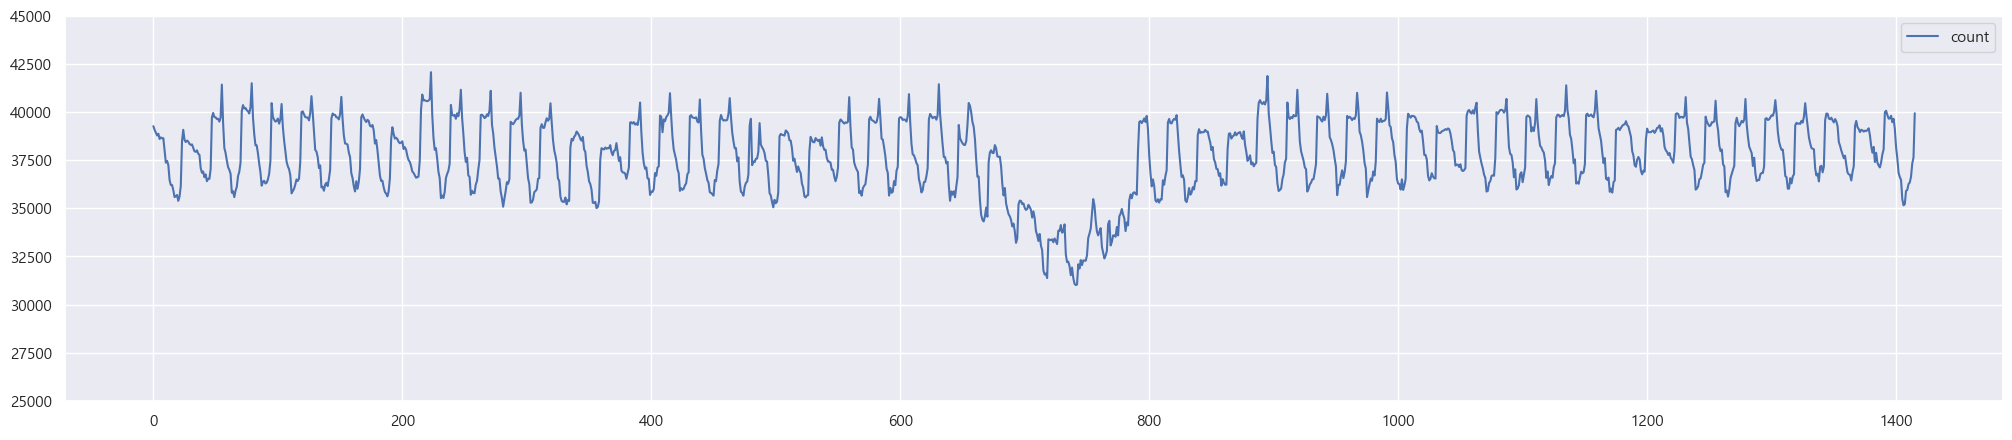

In [279]:
plt.figure(figsize=(25,5))
plt.plot(pred_best['count'],data=pred_best)
plt.ylim(25000,45000)
plt.legend()

In [280]:
# 각 연도별 + 예측 1월치 그래프 입니다

def makeplot(n) :
    a = df_total[df_total['year']==n].reset_index(drop=True)
    b = a[(a['month']==1) & (a['day']<=31)].reset_index(drop=True)
    
    c = df_total[df_total['year']==n-1].reset_index(drop=True)
    d = c[(c['month']==1) & (c['day']<=31)].reset_index(drop=True)
    
    f = df_total[df_total['year']==n-2].reset_index(drop=True)
    g = f[(f['month']==1) & (f['day']<=31)].reset_index(drop=True)
    
    e = pred_best[0:744]
    
    plt.figure(figsize=(20,4))
    plt.plot(b['총생활인구수'],data=b)
    plt.plot(d['총생활인구수'],data=d, color = 'orange')
    plt.plot(e['count'],data=e,color='green')
    plt.plot(g['총생활인구수'],data=g,color='grey')
    plt.title('blue:2021년, orange:2020년, grey:2019년, green:2022예측')


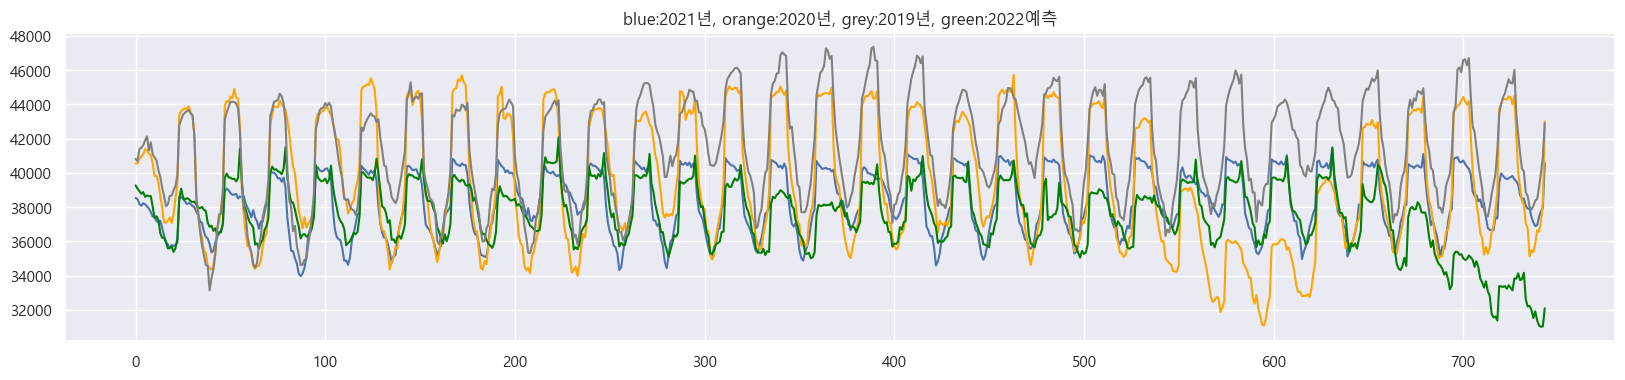

In [281]:
makeplot(2021)

In [282]:
# 첫 2주동안 예측값이 20년 값보다 크게 나온것이 이상하여 조정 (0.3,0.4,0.5 순으로 한 결과 0.4가 적당)
pred_best['count'][0:144] = pred_best['count'][0:144]*(9.6/10)

In [283]:
# 새해 첫날 12시까지는 다음날과 다다음날 보다 인구가 적은 것을 조정
pred_best['count'][0:12] = pred_best['count'][0:12]*(9.9/10)

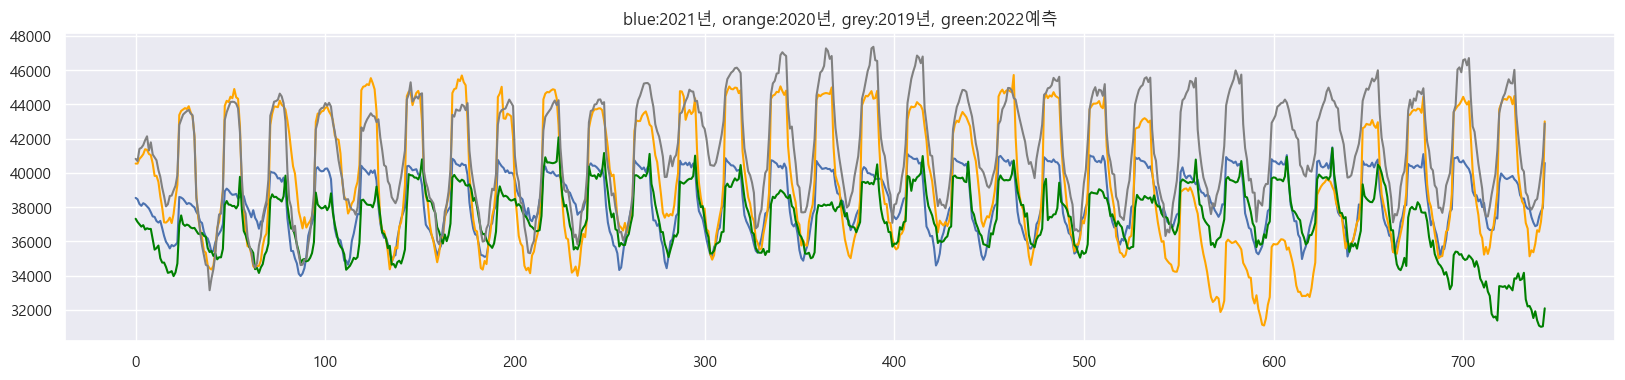

In [284]:
makeplot(2021)

In [239]:
pred_best.to_csv("pred_15.csv", index = False)

(25000.0, 45000.0)

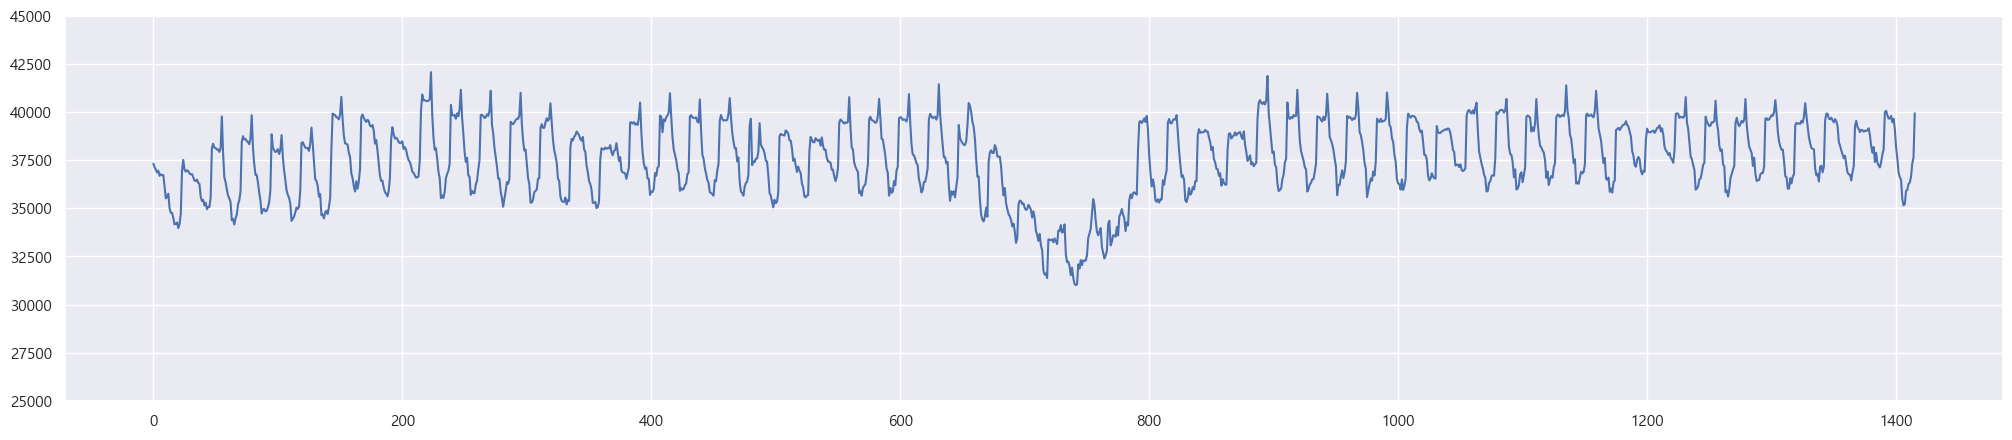

In [285]:
plt.figure(figsize=(25,5))
plt.plot(pred_best['count'],data=pred_best)
plt.ylim(25000,45000)